# Extracting Data from Quantrocket

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from quantrocket.license import set_license
set_license("2b416b15-de0e-11ee-b542-958e78a02bc9")

{'licensekey': '2b41........2bc9', 'software_license': {}}

In [ ]:
from quantrocket.master import collect_usstock_listings
collect_usstock_listings()

{'status': 'success', 'msg': 'already up-to-date'}

In [ ]:
from quantrocket.master import get_securities
securities = get_securities(symbols='AAPL', fields=['Sid', 'Symbol', 'Exchange'], vendors='usstock')

In [ ]:
from quantrocket.zipline import create_usstock_bundle
create_usstock_bundle("usstock-free-data",free = True)

{'status': 'success', 'msg': 'successfully created usstock-free-data bundle'}

In [ ]:
from quantrocket.zipline import ingest_bundle
ingest_bundle("usstock-free-data")

In [ ]:
from quantrocket import get_prices
data = get_prices("usstock-free-data", data_frequency='daily', sids="FIBBG000B9XRY4", start_date='2023-01-01', end_date='2023-12-31', fields=["Open","High","Low","Close"])

In [ ]:
df = data.reset_index()

In [ ]:
high = df[df['Field'] == 'High']
high = list(high['FIBBG000B9XRY4'])

In [ ]:
low = df[df['Field'] == 'Low']
low = list(low['FIBBG000B9XRY4'])

In [ ]:
open = df[df['Field'] == 'Open']
open = list(open['FIBBG000B9XRY4'])

In [ ]:
df = df[df['Field'] == 'Close']

In [ ]:
df['Open'] = open
df['High'] = high
df['low'] = low

In [ ]:
df.rename(columns={'FIBBG000B9XRY4': 'Close'}, inplace=True)

In [ ]:
df.to_csv("Stock_data.csv", index=False)

# Import Libraries

In [2]:
import warnings
import numpy as np
import pandas as pd
from math import sqrt
import statsmodels.api as sm
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [3]:
warnings.filterwarnings("ignore")

# Reading Data

In [5]:
# Read the CSV file
df = pd.read_csv("Stock_data.csv")

In [6]:
# Drop the column
df = df.drop("Field", axis=1)

In [7]:
df

,Date,Close,Open,High,low
0,2023-01-03,124.375,129.556,130.172,123.480
1,2023-01-04,125.658,126.185,127.941,124.385
2,2023-01-05,124.325,126.423,127.060,124.067
3,2023-01-06,128.900,125.310,129.566,124.196
4,2023-01-09,129.427,129.740,132.668,129.168
...,...,...,...,...,...
245,2023-12-22,193.600,195.180,195.410,192.970
246,2023-12-26,193.050,193.610,193.890,192.830
247,2023-12-27,193.150,192.490,193.500,191.090
248,2023-12-28,193.580,194.140,194.660,193.170


# Model

**Stock Price Model Inference:**

This Python class, named `Model`, encapsulates a simplistic Stock Price model designed to maximize portfolio value based on a straightforward trading strategy. The key functionalities are outlined below:

1. **`calculate_returns(self, price_history)`**: Computes daily returns from Close prices using the formula: r(d) = p(d) - p(d-1)p(d-1).

2. **`classify_state(self, returns)`**: Classifies daily returns into three states: Bull market (+1), Flat market (0), or Bear market (-1). Classification is based on specified threshold values.

3. **`calculate_transition_distribution(self, states)`**: Derives a transition distribution matrix representing the likelihood of transitioning between market states.

4. **`maximize_portfolio_value(self, price_history)`**: Implements the main strategy to maximize portfolio value. Buy signals occur when transitioning from a flat market to a bull market, and sell signals occur when transitioning to a bear market. The method returns the final portfolio value, indices of buy signals, a list of portfolio values at each step, and the transition distribution matrix.




In [9]:
import numpy as np

class Model():

    def calculate_returns(self, price_history):
        """
        Calculate daily returns from Close price.

        - r(d) be the % returns on day d.
        - r(d) = (p(d) - p(d-1))/p(d-1).
        """
        returns = np.diff(price_history) / price_history[:-1]
        returns = np.insert(returns, 0, 1)
        return returns

    def classify_state(self, returns):
        """
        Classify states based on daily returns.

        if r(d) >= 0.01, s(d) = +1
        else if r(d) > -0.01, s(d) = 0
        else, s(d) = -1

        - Bull (+1), Flat (0) or Bear (-1).
        """
        states = np.zeros(len(returns))
        states[returns >= 0.01] = 1
        states[(returns > -0.01) & (returns < 0.01)] = 0
        states[returns <= -0.01] = -1
        return states

    def calculate_transition_distribution(self, states):
        """
        Calculate transition distribution matrix based on classified states.

        """
        transition_matrix = np.zeros((3, 3))

        for i in range(1, len(states)):
            current_state = int(states[i-1] + 1)
            next_state = int(states[i] + 1)
            transition_matrix[current_state, next_state] += 1

        transition_distribution = transition_matrix / np.sum(transition_matrix, axis=1, keepdims=True)
        return transition_distribution

    def maximize_portfolio_value(self, price_history):
        """
        Maximize portfolio value based on trading strategy.

        Returns:
        - portfolio_value (float): Final portfolio value.
        - Buy_Indices (list): List of indices where buy signals occurred.
        - Values (list): List of portfolio values at each step.
        - transition_distribution (numpy.ndarray): Transition distribution matrix.
        """
        portfolio_value = 0
        price_history = list(price_history)

        returns = self.calculate_returns(price_history)
        states = self.classify_state(returns)

        Buy_Indices = []
        Values = [0]

        for i in range(1, len(states)):
            if states[i] == 1 and states[i-1] == 0:
                portfolio_value += 1
                Buy_Indices.append(i)
                Values.append(portfolio_value)
            elif states[i] == -1 and states[i-1] == 0:
                portfolio_value -= 1
                Values.append(portfolio_value)
            else:
                Values.append(portfolio_value)

        return portfolio_value, Buy_Indices, Values, self.calculate_transition_distribution(states)


# Fitting the Model for the Given Dataset

In [11]:
Given_Data = Model()

Values_for_GD = Given_Data.maximize_portfolio_value(df['Close'])

all_dates = df['Date']

print("Maximized Portfolio Value : ", Values_for_GD[0])
print("Optimal Buy Indices      : ", Values_for_GD[1])
optimal_dates = [all_dates[i] for i in Values_for_GD[1]]
print("Optimal Buy Dates         : ", optimal_dates)
print("Transition Distribution Matrix:")
np.set_printoptions(precision=4, suppress=True)

states = ['Bear', 'Flat', 'Bull']
i = 0

for row in Values_for_GD[3]:
  print(states[i], end="   ")
  i += 1
  for val in row:
    print(f"{val:.4f}", end=" ")
  print(end="\n")

print("       ", end=" ")
for i in states:
  print(i, end="   ")
print(end="\n")

Maximized Portfolio Value :  17
Optimal Buy Indices      :  [6, 8, 12, 16, 21, 28, 30, 41, 50, 52, 59, 61, 69, 79, 85, 88, 94, 100, 103, 108, 110, 113, 117, 120, 123, 133, 142, 160, 164, 177, 187, 191, 207, 209, 212, 216, 218, 232, 234, 238]
Optimal Buy Dates         :  ['2023-01-11', '2023-01-13', '2023-01-20', '2023-01-26', '2023-02-02', '2023-02-13', '2023-02-15', '2023-03-03', '2023-03-16', '2023-03-20', '2023-03-29', '2023-03-31', '2023-04-13', '2023-04-27', '2023-05-05', '2023-05-10', '2023-05-18', '2023-05-26', '2023-06-01', '2023-06-08', '2023-06-12', '2023-06-15', '2023-06-22', '2023-06-27', '2023-06-30', '2023-07-17', '2023-07-28', '2023-08-23', '2023-08-29', '2023-09-18', '2023-10-02', '2023-10-06', '2023-10-30', '2023-11-01', '2023-11-06', '2023-11-10', '2023-11-14', '2023-12-05', '2023-12-07', '2023-12-13']
Transition Distribution Matrix:
Bear   0.1429 0.7429 0.1143 
Flat   0.1465 0.5987 0.2548 
Bull   0.1228 0.6667 0.2105 
        Bear   Flat   Bull   


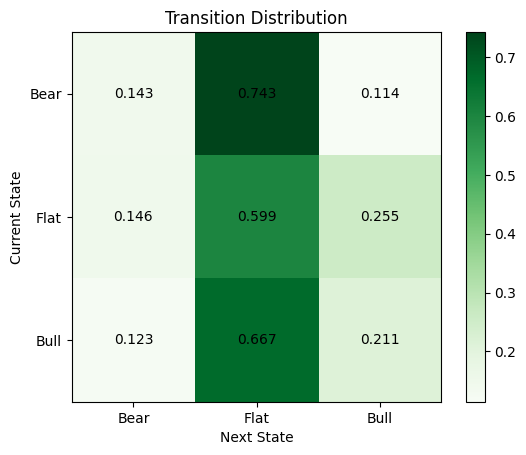

In [12]:
labels = ['Bear', 'Flat', 'Bull']
cmap = plt.get_cmap('Greens')

transition_distribution = Values_for_GD[3]

plt.imshow(transition_distribution, interpolation='nearest', cmap=cmap)
plt.title('Transition Distribution')
plt.colorbar()

plt.xticks(np.arange(3), labels)
plt.yticks(np.arange(3), labels)

plt.xlabel('Next State')
plt.ylabel('Current State')

for i in range(3):
  for j in range(3):
    plt.text(j, i, f'{transition_distribution[i, j]:.3f}', ha='center', va='center', color='black')

plt.show()

# Test For Arima

- **Test Type:**
  - KPSS test is employed to examine the stationarity of a time series.

- **Hypotheses:**
  - Null Hypothesis (H0): The time series is stationary around a deterministic trend.
  - Alternative Hypothesis (H1): The time series has a unit root and is non-stationary.

- **Test Results:**
  - Test Statistic: 1.715955
  - p-value: 0.010000
  - Critical Values: 10%, 5%, 2.5%, 1%

- **Inference:**
  - Since the p-value (0.01) is less than the significance level (0.05), we reject the null hypothesis.
  - Therefore, the time series is considered non-stationary.
  - The test statistic exceeding the critical values further supports the rejection of the null hypothesis.
  - The number of lags used in the test is 10.

- **Conclusion:**
  - The 'Close' time series is likely non-stationary, indicating the presence of a unit root or a deterministic trend.


In [13]:
def KPSS(timeseries):
    print('Results of KPSS Test:')

    # Perform the KPSS test with constant term ('c') regression and automatic lag selection
    kpss_test = kpss(timeseries, regression='c', nlags="auto")

    kpss_output = pd.Series(kpss_test[0:3], index=['Test Statistic', 'p-value', '#Lags Used'])

    # Add critical values to the output Series
    for key, value in kpss_test[3].items():
        kpss_output['Critical Value (%s)' % key] = value

    print(kpss_output)

# Apply the KPSS test to the 'Close' column of the DataFrame 'df'
KPSS(df['Close'])

Results of KPSS Test:
Test Statistic            1.715955
p-value                   0.010000
#Lags Used               10.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


**Inference based on the Dickey-Fuller test results:**

- **Test Type:**
  - Dickey-Fuller test is employed to assess the stationarity of a time series.

- **Hypotheses:**
  - Null Hypothesis (H0): The time series has a unit root and is non-stationary.
  - Alternative Hypothesis (H1): The time series is stationary.

- **Test Results:**
  - Test Statistic: -2.586111
  - p-value: 0.095902
  - #Lags Used: 0
  - Number of Observations Used: 249

- **Critical Values:**
  - Critical Value (1%): -3.456888
  - Critical Value (5%): -2.873219
  - Critical Value (10%): -2.572994

- **Inference:**
  - The p-value (0.095902) is greater than the significance level (commonly 0.05).
  - We fail to reject the null hypothesis, suggesting insufficient evidence to conclude stationarity.
  - The test statistic (-2.586111) is less negative than critical values, further supporting non-rejection.
  - Consider additional analysis or differencing to explore stationarity further.

- **Conclusion:**
  - The 'Close' time series may be non-stationary based on the Dickey-Fuller test, but further investigation is recommended.


In [14]:
def ADF(timeseries):
    print('Results of Dickey-Fuller Test:')

    # Perform the Dickey-Fuller test with automatic lag selection using AIC
    adf_test = adfuller(timeseries, autolag='AIC')

    adf_output = pd.Series(adf_test[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])

    # Add critical values to the output Series
    for key, value in adf_test[4].items():
        adf_output['Critical Value (%s)' % key] = value

    print(adf_output)

# Apply the Dickey-Fuller test to the 'Close' column of the DataFrame 'df'
ADF(df['Close'])

Results of Dickey-Fuller Test:
Test Statistic                  -2.586111
p-value                          0.095902
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


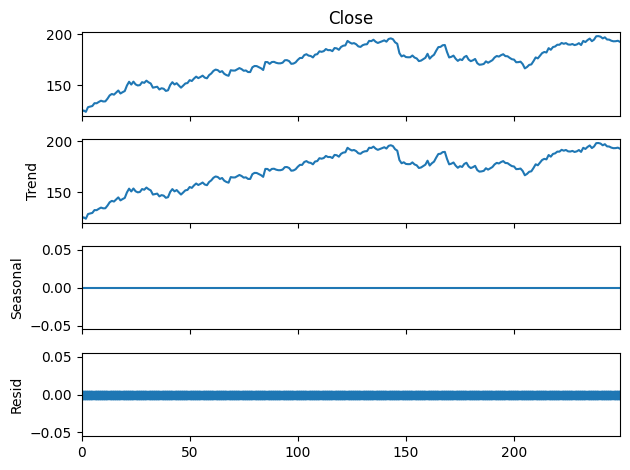

In [15]:
decomposition = sm.tsa.seasonal_decompose(df['Close'], model='additive', period=1)
fig = decomposition.plot()
plt.show()

**Inference based on Stationarity Tests after First-Order Differencing:**

- **Objective:**
  - From the two test conducted above, it as resulted that the dataset is non-stationary
  - Both KPSS and ADF tests suggest that the dataset becomes stationary after first-order differencing.
  - This transformation enhances the suitability of the data for time series analysis.


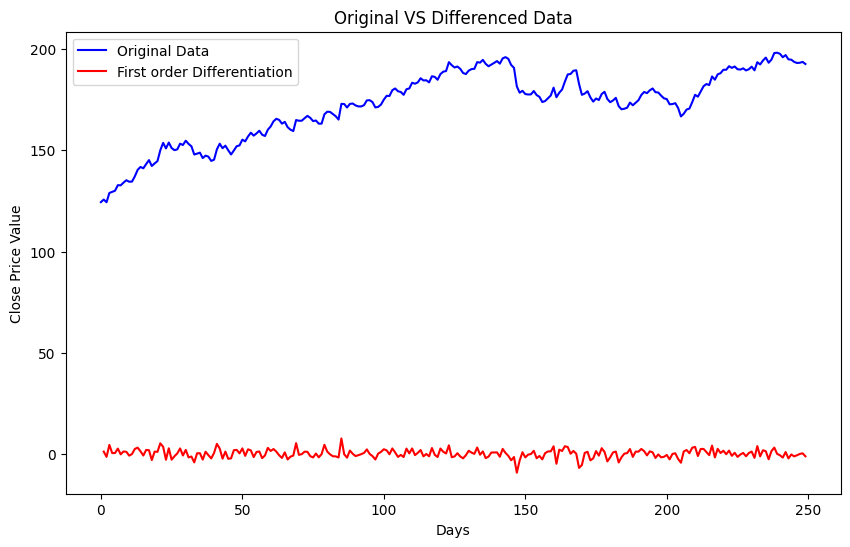

In [17]:
time_data=df['Close']
differenced_data = time_data.diff(periods = 1)
differenced_data = differenced_data.dropna()
plt.figure(figsize=(10, 6))
plt.plot(time_data, label='Original Data' ,color='blue')
plt.plot(differenced_data, label='First order Differentiation' ,color='red')
plt.xlabel('Days')
plt.ylabel('Close Price Value')
plt.title('Original VS Differenced Data')
plt.legend()
plt.show()

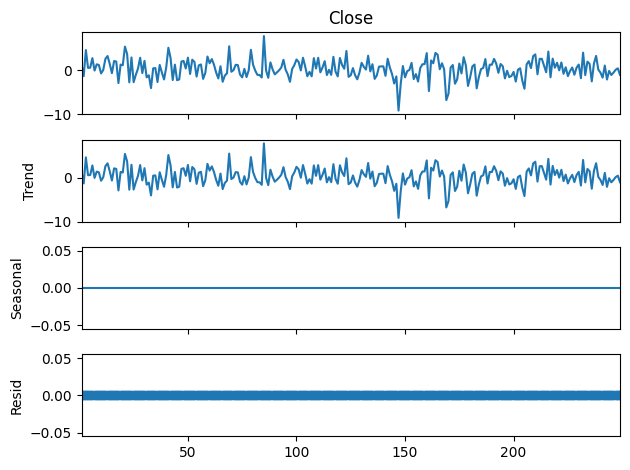

In [18]:
decomposition = sm.tsa.seasonal_decompose(differenced_data , model='additive',period=1)
fig = decomposition.plot()
plt.show()

**Inference for ACF (AutoCorrelation Function) - Parameter Selection:**

- **Objective:**
  - ACF is used to analyze the autocorrelation structure in time series data, aiding in parameter selection for time series models.

- **Interpretation of ACF:**
  - Peaks and valleys in the ACF plot indicate the strength and direction of autocorrelation at different lags.
  - Positive peaks suggest positive autocorrelation, and negative peaks suggest negative autocorrelation.
  - Lags with values close to 0 indicate weak or no autocorrelation.

- **Parameter Selection:**
  - Identify significant lags in the ACF plot based on their heights.
  - Significant lags may help determine the order (q) for AutoRegressive (AR) models.

- **Rules of Thumb:**
  - Select the lag where the ACF drops to insignificance (within confidence intervals).
  - For an AR(q) model, consider lags up to q where the ACF values are significant.


- **Conclusion:**
  - From the graph the value of q is 18


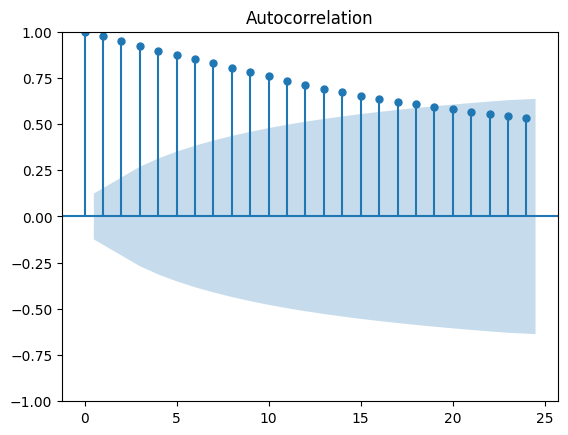

In [19]:
plot_acf(df['Close'])
plt.show()

**Inference for PACF (Partial Autocorrelation Function):**

- **Purpose:**
  - PACF is used to identify the direct relationship between a time series and its lagged values, removing the influence of intervening observations.

- **Interpretation:**
  - Significant positive partial autocorrelation at lag k suggests a direct influence.
  - Significant negative partial autocorrelation at lag k indicates a possible over-differencing.

- **Parameter Selection:**
  - Lag values with significant spikes guide the choice of the 'p' parameter in an ARIMA model.
  - Examine where partial autocorrelation drops off to identify the autoregressive behavior.

- **Conclusion:**
  - From the graph value of p is 1


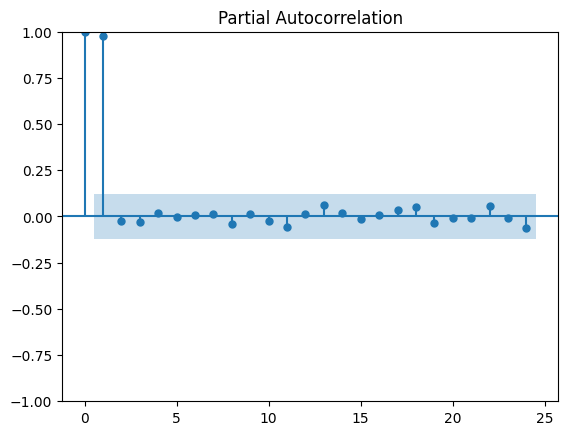

In [20]:
plot_pacf(df['Close'])
plt.show()

**ARIMA Model Evaluation and Conclusion:**

This Python script utilizes the ARIMA (AutoRegressive Integrated Moving Average) model for time series forecasting of stock prices. Here's a summary of the key steps and evaluation:

1. **Data Splitting:**
   - The historical closing prices (`df['Close']`) are split into training and test sets, with a split ratio of 66:34.

2. **Model Training and Prediction:**
   - The ARIMA model is trained using the training data.
   - Walk-forward validation is performed, where the model is iteratively trained on historical data and used to predict future values.

3. **Evaluation:**
   - Root Mean Squared Error (RMSE) is calculated to evaluate the accuracy of the model's predictions.
   - The calculated RMSE value is approximately 2.347.

4. **Conclusion:**
   - The ARIMA model achieves an RMSE value of 2.347, indicating the average deviation of predicted stock prices from the actual values.
   - Lower RMSE values signify better model performance, as they indicate smaller prediction errors.
   - Based on the obtained RMSE value, this ARIMA model demonstrates reasonably good performance in forecasting stock prices.
   - However, further analysis and experimentation with different model parameters may be necessary to improve forecasting accuracy.



In [21]:
X = df['Close'].values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

# walk-forward validation
for t in range(len(test)):
  model = ARIMA(history, order=(1,1,18))
  model_fit = model.fit()
  output = model_fit.forecast()
  yhat = output[0]
  predictions.append(yhat)
  obs = test[t]
  history.append(obs)

# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE-Value: %.3f' % rmse)

RMSE-Value: 2.347


# Arima Model

**ARIMA Forecasting Function Inference:**

The provided Python function, `arima(step, x)`, performs time series forecasting using the ARIMA (AutoRegressive Integrated Moving Average) model. Here's a breakdown of the key steps:

1. **Data Preparation:**
   - The function takes two parameters: `step` (the number of days to forecast into the future) and `x` (a pandas Series containing the time series data).
   - The historical time series data is extracted from the Series `x`.

2. **Model Training:**
   - The entire dataset is used for training the ARIMA model.
   - The model is initialized with an ARIMA order of (1, 1, 18)(Note: Values are determinded by the test conducted above).
   - The model is fitted to the training data.

3. **Forecasting:**
   - Future values are forecasted for the specified number of days (`step`).
   - The original stock prices and the forecasted values are combined to create an extended time series.

4. **Date Generation:**
   - Future dates for the forecast are generated based on the last date in the original dataset.
   - Weekday dates are considered, excluding weekends.

5. **Output:**
   - The function returns two lists: `dates` (containing the future dates) and `stock_price` (containing the historical and forecasted stock prices).


In [ ]:
def arima(step, x):
    X = x.values

    # Use the entire dataset for training
    train = X

    # Initialize the history list with the training data
    history = [x for x in train]

    predictions = list()

    # Fit an ARIMA model with order (1,1,18)
    model = ARIMA(history, order=(1, 1, 18))
    model_fit = model.fit()

    # Forecast future values for the specified number of days
    forecast_value = model_fit.forecast(steps=step)

    stock_price = list(df['Close'])

    # Extend the original stock prices with the forecasted values
    stock_price.extend(forecast_value)

    last_date = pd.to_datetime(df.iloc[len(df) - 1]['Date'])

    # Generate future dates for the forecast
    dates = []
    days_to_add = 1

    while len(dates) < step:
        next_date = last_date + timedelta(days=days_to_add)

        # Check if the next date is a weekday (Monday to Friday)
        if next_date.weekday() < 5:
            dates.append(next_date.strftime("%Y-%m-%d"))

        days_to_add += 1

    return dates, stock_price


# Calculating the No.Of Days

In [ ]:
def get_day_of_week(date_string):
    try:
        # Get the day of the week as an integer (Monday=0, Sunday=6)
        day_of_week = date_string.weekday()
        # Convert the integer day of the week to a string representation
        days_name = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        given_day_name = days_name[day_of_week]
        return given_day_name
    except ValueError:
        return "Invalid date format. Please provide date in YYYY-MM-DD format."

def calculate_weekdays(end_date, start_date=None):
    if start_date is None:
        start_date = datetime(2023, 12, 29)

    if get_day_of_week(end_date) in ['Saturday', 'Sunday']:
        print("It's " + get_day_of_week(end_date) + ", we can't buy Stocks")
        return 0
    elif start_date > end_date:
        return -1
    else:
        current_date = start_date + timedelta(days=1)
        weekdays_count = 0
        while current_date < end_date:
            if current_date.weekday() < 5:
                weekdays_count += 1
            current_date += timedelta(days=1)
        return weekdays_count

In [ ]:
def extract_date_parts(date_string):
    # Extract year, month, and day from a date string
    date_obj = datetime.strptime(date_string, "%Y-%m-%d")
    year = date_obj.year
    month = date_obj.month
    day = date_obj.day
    return year, month, day

# Calling the Function

**Stock Portfolio Optimization Inference:**

This Python script employs a financial model, represented by the `Model` class, to optimize stock portfolio values. Here's a breakdown of the key steps:

1. **User Input:**
   - The user is prompted to enter a date in the format (yyyy-mm-dd).
   - The script extracts year, month, and day from the input.

2. **Date Processing:**
   - The last date is calculated based on the user input.
   - The number of weekdays between the last date and the last date of the Close price data avaliable is computed.

3. **ARIMA Forecasting and Portfolio Optimization:**
   - If there are future weekdays for which predictions are needed:
     - The ARIMA model is used to forecast stock prices for upcoming weekdays.
     - The portfolio value is maximized using the forecasted stock prices.
     - Optimal buy indices, dates, and the transition distribution matrix are printed.
     - The script informs whether to buy the stock on the last entered date based on portfolio performance.

   - If there are no upcoming weekdays for which predictions are needed:
     - A message is displayed indicating that stock purchase is not recommended on previous dates.

4. **Output:**
   - The script provides insights into the maximized portfolio value, optimal buy indices, dates, and the transition distribution matrix.
   - The user is informed about the recommendation to buy or not buy the stock on the last entered date.



In [ ]:
obj = Model()

date_string = str(input("Enter date in (yyyy-mm-dd): "))
year, month, day = extract_date_parts(date_string)

last_date = datetime(year, month, day)  # Last date mentioned

# Calculate the number of weekdays between the last date and the current date
no_of_days = calculate_weekdays(last_date)

# Check if there are future weekdays for which predictions are needed
if no_of_days > 0:
    # Use the ARIMA model to forecast stock prices for the upcoming weekdays
    Close_price = arima(no_of_days, df['Close'])

    all_dates = list(df['Date'])
    all_dates.extend(Close_price[0])

    # Maximize the portfolio value using the calculated stock prices
    Values = obj.maximize_portfolio_value(Close_price[1])

    # Check if the portfolio value increased from the last day
    if Values[2][-1] > Values[2][-2]:
        print("Maximized Portfolio Value: ", Values[0])
        print("Optimal Buy Indices     : ", Values[1])
        optimal_dates = [all_dates[i] for i in Values[1]]
        print("Optimal Buy Dates        : ", optimal_dates)
        print("Transition Distribution Matrix:")
        np.set_printoptions(precision=4, suppress=True)

        states = ['Bear', 'Flat', 'Bull']
        i = 0

        for row in Values[3]:
            print(states[i], end="   ")
            i += 1
            for val in row:
                print(f"{val:.4f}", end=" ")
            print(end="\n")

        print("       ", end=" ")
        for i in states:
            print(i, end="   ")
        print(end="\n")
        print("You can Buy the Stock", last_date.strftime("%Y-%m-%d"))

    else:
        print("Maximized Portfolio Value : ", Values[0])
        print("Optimal Buy Indices      : ", Values[1])
        optimal_dates = [all_dates[i] for i in Values[1]]
        print("Optimal Buy Dates         : ", optimal_dates)
        print("Transition Distribution Matrix:")
        np.set_printoptions(precision=4, suppress=True)

        states = ['Bear', 'Flat', 'Bull']
        i = 0

        for row in Values[3]:
            print(states[i], end="   ")
            i += 1
            for val in row:
                print(f"{val:.4f}", end=" ")
            print(end="\n")

        print("       ", end=" ")
        for i in states:
            print(i, end="   ")
        print(end="\n")
        print("You don't Buy the Stock on", last_date.strftime("%Y-%m-%d"))

# Check if there are no upcoming weekdays for which predictions are needed
elif no_of_days == -1:
    print("You can't buy the stock on previous dates")


Enter date in (yyyy-mm-dd): 2024-01-10
Maximized Portfolio Value :  17
Optimal Buy Indices      :  [6, 8, 12, 16, 21, 28, 30, 41, 50, 52, 59, 61, 69, 79, 85, 88, 94, 100, 103, 108, 110, 113, 117, 120, 123, 133, 142, 160, 164, 177, 187, 191, 207, 209, 212, 216, 218, 232, 234, 238]
Optimal Buy Dates         :  ['2023-01-11', '2023-01-13', '2023-01-20', '2023-01-26', '2023-02-02', '2023-02-13', '2023-02-15', '2023-03-03', '2023-03-16', '2023-03-20', '2023-03-29', '2023-03-31', '2023-04-13', '2023-04-27', '2023-05-05', '2023-05-10', '2023-05-18', '2023-05-26', '2023-06-01', '2023-06-08', '2023-06-12', '2023-06-15', '2023-06-22', '2023-06-27', '2023-06-30', '2023-07-17', '2023-07-28', '2023-08-23', '2023-08-29', '2023-09-18', '2023-10-02', '2023-10-06', '2023-10-30', '2023-11-01', '2023-11-06', '2023-11-10', '2023-11-14', '2023-12-05', '2023-12-07', '2023-12-13']
Transition Distribution Matrix:
Bear   0.1429 0.7429 0.1143 
Flat   0.1402 0.6159 0.2439 
Bull   0.1228 0.6667 0.2105 
        Be

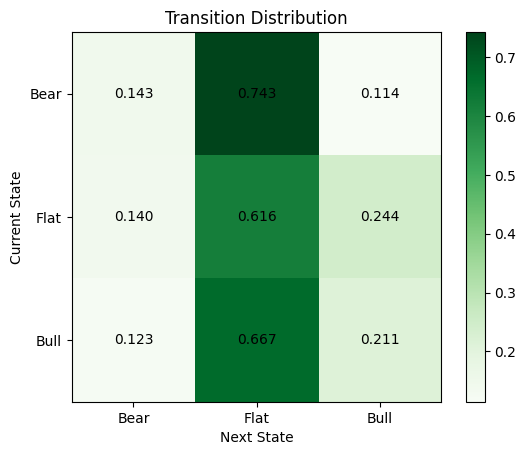

In [ ]:
labels = ['Bear', 'Flat', 'Bull']
cmap = plt.get_cmap('Greens')

transition_distribution = Values[3]

plt.imshow(transition_distribution, interpolation='nearest', cmap=cmap)
plt.title('Transition Distribution')
plt.colorbar()

plt.xticks(np.arange(3), labels)
plt.yticks(np.arange(3), labels)

plt.xlabel('Next State')
plt.ylabel('Current State')

for i in range(3):
  for j in range(3):
    plt.text(j, i, f'{transition_distribution[i, j]:.3f}', ha='center', va='center', color='black')

plt.show()